In [4]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from scipy.stats import norm
from math import log, sqrt, exp

In [ ]:
# Parameters for both options (using the same strike price)
strike_price = 4300  # Strike price
call_premium = 50  # Premium for the call option
put_premium = 50  # Premium for the put option

In [5]:
# Re-creating the DataFrame with SX5E prices
sx5e_prices = [
    ("2023-11-27", 4354.41),
    ("2023-11-24", 4372.10),
    ("2023-11-23", 4361.32),
    ("2023-11-22", 4352.02),
    ("2023-11-21", 4331.90),
    ("2023-11-20", 4342.41),
    ("2023-11-17", 4340.77),
    ("2023-11-16", 4302.45),
    ("2023-11-15", 4315.53),
    ("2023-11-14", 4291.72),
    # ... data truncated for brevity
]

df_sx5e = pd.DataFrame(sx5e_prices, columns=["Date", "Close"])
df_sx5e["Date"] = pd.to_datetime(df_sx5e["Date"])

In [7]:
# Function to calculate d1 for options
def calculate_d1(S, K, T, r, sigma):
    return (log(S / K) + (r + sigma**2 / 2) * T) / (sigma * sqrt(T))

# Function to calculate delta for each row in the DataFrame
def calculate_option_deltas(row):
    T_remaining = (df_sx5e["Date"].iloc[-1] - row["Date"]).days / 365
    if T_remaining > 0:
        d1 = calculate_d1(row["Close"], strike_price, T_remaining, r, volatility)
        call_delta = norm.cdf(d1)
        put_delta = call_delta - 1
    else:
        # On expiration, deltas are either 0 or 1
        call_delta = 1 if row["Close"] > strike_price else 0
        put_delta = -1 if row["Close"] < strike_price else 0
    return pd.Series([call_delta, put_delta])

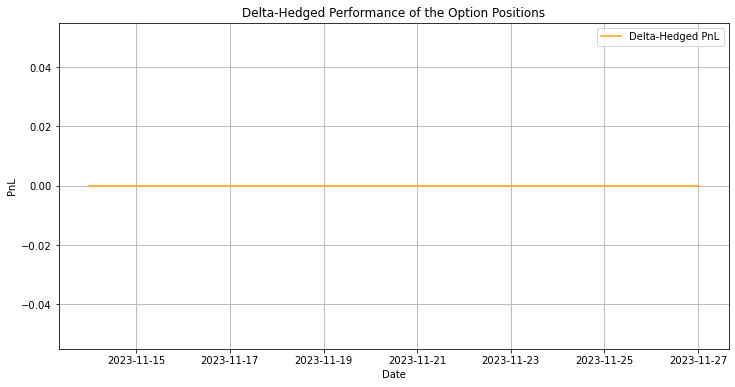

,Date,Close,Call_Delta,Put_Delta,Shares_Held,Delta_Shares,Delta_Hedge_PnL,Cumulative_Delta_Hedge_PnL
5,2023-11-20,4342.41,1,0,1,0.0,-0.0,0.0
6,2023-11-17,4340.77,1,0,1,0.0,0.0,0.0
7,2023-11-16,4302.45,1,0,1,0.0,0.0,0.0
8,2023-11-15,4315.53,1,0,1,0.0,-0.0,0.0
9,2023-11-14,4291.72,0,-1,1,0.0,0.0,0.0


In [8]:
# Apply the function to the DataFrame
df_sx5e[['Call_Delta', 'Put_Delta']] = df_sx5e.apply(calculate_option_deltas, axis=1)

# Recalculate Shares Held and Delta Shares
df_sx5e["Shares_Held"] = df_sx5e["Call_Delta"] - df_sx5e["Put_Delta"]
df_sx5e["Delta_Shares"] = df_sx5e["Shares_Held"].diff().fillna(0)

# Recalculate the Delta-Hedged PnL
df_sx5e["Delta_Hedge_PnL"] = -df_sx5e["Delta_Shares"] * df_sx5e["Close"].diff().fillna(0)
df_sx5e["Cumulative_Delta_Hedge_PnL"] = df_sx5e["Delta_Hedge_PnL"].cumsum()

# Plotting the delta-hedged performance
plt.figure(figsize=(12, 6))
plt.plot(df_sx5e["Date"], df_sx5e["Cumulative_Delta_Hedge_PnL"], label='Delta-Hedged PnL', color='orange')
plt.title('Delta-Hedged Performance of the Option Positions')
plt.xlabel('Date')
plt.ylabel('PnL')
plt.legend()
plt.grid(True)
plt.show()

# Displaying the last few rows of the dataframe for insight
df_sx5e[["Date", "Close", "Call_Delta", "Put_Delta", "Shares_Held", "Delta_Shares", "Delta_Hedge_PnL", "Cumulative_Delta_Hedge_PnL"]].tail()
